In [1]:
from google.colab import drive

drive.mount("/content/drive")
%cd "/content/drive/MyDrive/OMSCS/cs7643-dl-project/"

!pip install -U torchtext==0.8.1
!pip install -U torchvision==0.8.2
!pip install -U spacy==2.3.5
!python -m spacy download en

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/OMSCS/cs7643-dl-project
     |████████████████████████████████| 12.0 MB 8.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
# !bash "data/get_flickr8k_dataset.sh"

In [130]:
!ls data

CrowdFlowerAnnotations.txt  Flickr8k.lemma.token.txt   get_flickr8k_dataset.sh
ExpertAnnotations.txt	    Flickr_8k.testImages.txt   __MACOSX
Flicker8k_Dataset	    Flickr8k.token.txt	       readme.txt
Flickr_8k.devImages.txt     Flickr_8k.trainImages.txt


In [83]:
import os
import random

from tqdm import tqdm

import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
from dataset import get_data_loader
from params import MIN_FREQ, EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, LEARNING_RATE, NUM_EPOCHS
from model import CNNtoRNN

%reload_ext autoreload
%autoreload 2

In [85]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [86]:
image_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)
train_dataloader, train_dataset = get_data_loader(
                                                  data_type="train", 
                                                  transforms=image_transforms,
                                                  lang="en",
                                                  lower=True,
                                                  min_freq=5, 
                                                  text_field=None,
                                                  batch_size=128,
                                                  num_workers=4,
                                                  shuffle=True,
                                                  pin_memory=True
                                                  )
train_text_field = train_dataset.text_field
VOCAB_SIZE = len(train_text_field.vocab)

dev_dataloader, dev_dataset = get_data_loader(
                                              data_type="dev", 
                                              transforms=image_transforms,
                                              lang="en",
                                              lower=True,
                                              min_freq=5, 
                                              text_field=train_text_field,
                                              batch_size=128,
                                              num_workers=4,
                                              shuffle=False,
                                              pin_memory=True
                                              )

test_dataloader, test_dataset = get_data_loader(
                                              data_type="test", 
                                              transforms=image_transforms,
                                              lang="en",
                                              lower=True,
                                              min_freq=5, 
                                              text_field=train_text_field,
                                              batch_size=128,
                                              num_workers=4,
                                              shuffle=False,
                                              pin_memory=True
                                              )

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed_everything(2022)
model = CNNtoRNN(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_text_field.vocab.stoi["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for name, param in model.encoderCNN.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True

model.train()
for epoch in range(50):
    print(f"Epoch: {epoch + 1}")
    for idx, (image_filenames, image_nums, text_captions, images, captions) in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader), leave=False):
        images = images.to(device)
        captions = captions.to(device)

        outputs = model(images, captions[:-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )
        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()

Epoch: 1


Epoch: 2


Epoch: 3


KeyboardInterrupt: ignored

In [141]:
def caption_image(model, dataset, idx=None):
    if idx is not None:
        image_filename, image_num, text_caption, image, caption = dataset[idx]
    else:
        idx = np.random.choice(len(dataset))
        image_filename, image_num, text_caption, image, caption = dataset[idx]
    test_image = image.unsqueeze(0)
    model.eval()
    predicted_caption = model.caption_image(test_image.to(device), train_text_field.vocab)
    return image_filename, test_image, text_caption, " ".join(predicted_caption[1:-1])

In [142]:
image_filename, test_image, text_caption, predicted_caption = caption_image(model, test_dataset)

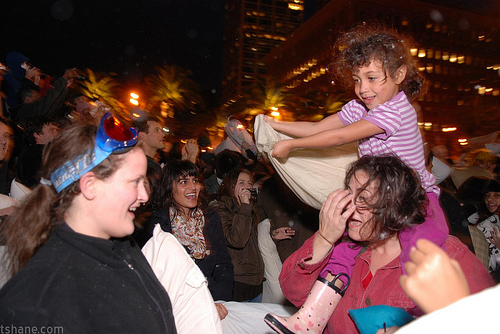

In [143]:
im = Image.open(f"data/Flicker8k_Dataset/{image_filename}");im

In [144]:
print(f"True caption: {text_caption}")
print(f"Predicted caption: {predicted_caption}")

True caption: Two women and a child celebrating at a nighttime party .
Predicted caption: a man in a red shirt is running on a <unk> .
